# Deutsch-Jozsa Algorithm In Real Life

Deutsch's algorithm, which was later generalized to the Deutsch-Josza algorithm, was the first quantum algorithm with an exponential speed-up compared to any classical algorithm. That's what made it a big deal even though it doesn't answer a useful question. It showed that there probably exists a quantum algorithm that is exponentially faster AND solves a useful question. In my [last post](https://appliedqc.org/2020/02/27/Deutsch-Jozsa-Algorithm.html), I went through the algorithm and did a little implementation, but <strong>something was missing</strong>. If the big news about Deutsch-Jozsa is that it's exponentially faster than a classical computer, I should do some time trials to if that's really true: <strong>CLASSICAL</strong> vs. <strong>QUANTUM</strong>. Let's get to it!

In [1]:
import numpy as np
import random
import time

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from qiskit import *

## Review: Deutsch-Jozsa Problem (and algorithm)
The problem goes like this: Given an unknown binary function $f(x)$ (aka black box or oracle) that maps $n$ input bits to one output bit, i.e. $f(x):\{0,1\}^n \rightarrow\{0,1\}$, determine if $f(x)$ is constant or balanced. A constant function means no matter what binary number $x$ we input, $f(x)$ will always output the same value. A balanced function means half of all possible input $x$'s give $f(x)=0$ while the other half give $f(x)=1$.

### Quantum Algorithm
And, if you remember, the algorithm went something like this:
![png](Deutsch-Jozsa_algo.png)
The output qubit (at the bottom) is 'marked' by applying the x gate. Then the qubits are parallelized with the column of H's into an equal superposition of all possible input and output states. Since the output qubit was marked, it has a different phase from the superposition of the input qubits. $U_f$ imprints $f(x)$ as a phase in the superposition state of the qubits (phase kickback). The second column of H's interferes the superposition state with itself and—if you do the math—finishes with the input qubits' final state as all 0's <strong>only</strong> for a constant function. If we measure <strong>any other</strong> state from the input qubits, we know $f(x)$ is a balanced function.

### Classical Algorithm
The classical way to determine if $f(x)$ is constant or balanced is to randomly input binary numbers until either: (1) the function has output both a 0 and 1 or (2) we've tried one more than half of all possible inputs ($2^{n-1}+1$ possibilities) getting the same output from $f(x)$. For case (1), since the function output a 0 and 1, we know it must be balanced. For case (2), the function output the same value for one more than half of all possible inputs, so $f(x)$ cannot be balanced. Since there are only two options for what $f(x)$ is, $f(x)$ must be constant. 

Notice the worst case scenario is when the algorithm will takes $2^{n-1}+1$ executions of $f(x)$. However, the best case scenario is a balanced function with just $2$ executions.

Obviously, if the classical algorithm finds the answer in $2$ executions, current quantum computers don't have chance as beating them. Let's help the quantum computer out by <strong>just</strong> doing <strong>constant functions</strong>. Yes, the classical algorithm is exponentially slower, but if each execution is million times faster than a current quantum computers... maybe the classical algorithm still takes less time overall. <strong>At what point would a quantum computer beat out a classical computer and is that point accessible with today's quantum computers?</strong>

## Define Constant Functions
Our first step is to build a constant function that can be run on a classical and quantum computer. Which turns out to be very easy to do for both types of computers. For classical, totally ignore the input and have the function always return 0 or always return 1.

In [2]:
# Two possible constant functions for a classical computer
def f_const0(x):
    return 0

def f_const1(x):
    return 1

## Deterministic Classical Algorithm
Now that we have some functions, let's layout the details of our classical algorithm. The algorithm will unknowingly ingest a constant function $f$ and the number of input bits $n$. I'd like it to randomly choose binary numbers to input, but when I did that for ~$n>20$ my laptop took a looonnnng time just to generate the random numbers—not including the time to input them into the function. If we were considering balanced functions, I'd bite the bullet and definitely do random inputs... But, since we know the functions are constant, ;) we'll just start from 0 and increment up to $2^{n-1}+1$! (I left the random number generating in there in case anyone wanted to try it out. just replace ```for x in non_random_inputs:``` with ```for x in random_inputs:``` and uncomment the definition of the random_inputs array).

If the algorithm loop gets to the $2^{n-1}+1$th input (one more than half the possible binary numbers for the given $n$) and gets the same output from $f(x)$ every time, it'll return a 0 indicating $f(x)$ is a constant function. If $f(x)$ outputs something different than a previous execution, we know it can't be a constant function. We'll immediately break and return a 1 indicating $f(x)$ is a balanced function. Of course, we know it will always be a constant function, but might as well make it work for the balanced function case. We'll include some approximate time keeping in the classical algorithm so we can compare it to the quantum algorithm.

In [3]:
# Helper function to convert between base 10 and base 2 (binary) numbers
def dec_to_binary(x):
    return int(bin(x)[2:])


# Input function and number of bits. Returns 0 if f is constant and 1 if f is balanced
def classical_algo(f, n):
    # Generate random inputs
    # random_inputs = random.sample(range(2**n), 2**(n-1)+1)  # 2^(n-1) + 1 unique random samples from 0 to 2^n - 1
    # Generate non_random inputs
    non_random_inputs = np.arange(2**(n-1) + 1)
    # Convert inputs into 'binary'
    binary_inputs = []
    for x in non_random_inputs:
        binary_inputs.append(dec_to_binary(x))
    # Determine if f is balanced or constant
    outputs = []  # initialize list to later store outputs
    start_time = time.time()  # start timing
    for i, x in enumerate(binary_inputs):  # iterate through random inputs
        outputs.append(f(x))  # keep track of f(x) outputs
        if i > 1:
            if outputs[i-1] != outputs[i]:  # if outputs is different from previous f(x), f must be balanced
                end_time = time.time()
                return 1, (end_time - start_time)  # BALANCED FUNCTION
    # if we get this far, 50% + 1 of the possible inputs gave the same output. Therefore, f must be constant.
    end_time = time.time()
    return 0, (end_time - start_time)  # CONSTANT FUNCTION


## Timed Trial: Classical Algorithm
Now that we have our algorithm ready and timed, let's run it! A LOT! We can try a small range of bits and run each $n$ value ~100 or more. That should be enough to get some good statistics on its variability. Let's also see if $n$ vs run time scales like $2^{n-1}$ as the theory suggests. Though I defined two constant functions, we'll just use the first one.

In [118]:
# This will run for 30-40 minutes

reps = 100  # number of repeated timings so we can get some statistics
ns_con = np.arange(1, 25)  # number of bits to consider in algo
f_consts = [f_const0, f_const1]

# Initialize arrays that will store results
const_time = np.zeros(len(ns_con) * reps)
labels = np.zeros(len(ns_con) * reps)

for j in range(reps):
    for i, n in enumerate(ns_con):
        index = i + j*len(ns_con)
        labels[index], const_time[index] = classical_algo(f_consts[0], n)

In [119]:
# Compute run time means and standard deviations for each n
const_time = const_time.reshape(reps, len(ns_con))
const_time_means = np.mean(const_time, axis=0)
const_time_stds = np.std(const_time, axis=0)

Average label should be exactly 0: 0.0


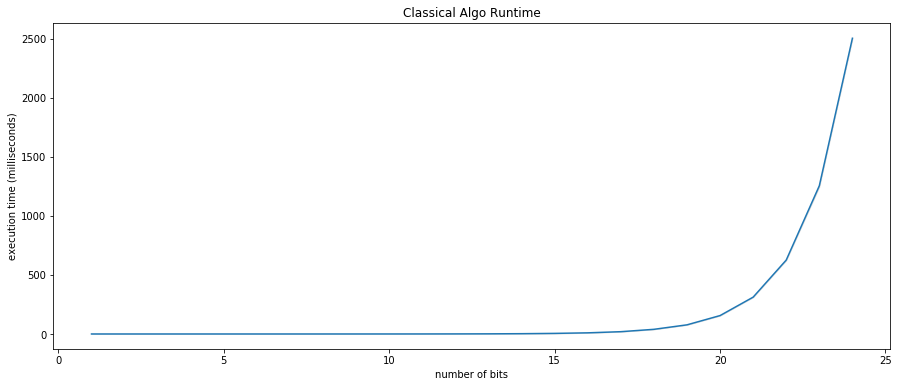

In [120]:
# Check it labeled the function correctly
print("Average label should be exactly 0:", np.mean(labels))

# Conversion factor from seconds to milliseconds
millisec = 1e3
# Conversion factor from seconds to microseconds
microsec = 1e6

# Plot time it took to run algo
plt.figure(figsize=(15,6))
plt.plot(ns_con, const_time_means * millisec)
plt.fill_between(ns_con, (const_time_means-const_time_stds) * millisec, 
                 (const_time_means+const_time_stds) * millisec, alpha=0.1, color='k')

plt.title('Classical Algo Runtime')
plt.xlabel('number of bits')
plt.ylabel('execution time (milliseconds)')
plt.show()

Wow, that's <strong><em>very</em></strong> exponential—just like we expected! The blue line is the mean runtime for a given number of bits. The gray shadow that outlines the first standard deviation from the mean is so small, it can't be seen. Let's fit the means to a function of the form $a 2^{b(n-1)} + c$. From the theory we talked about before, we expect the runtime $T \propto 2^{n-1}$, so $b$ should be $1$. The $a$ and $c$ parameters aren't important because they're not part of the exponential. $b$ IS really important because it tells us how fast the exponential grows with $n$.

Fit parameters: [ 3.01288381e-07  9.99435938e-01 -1.31329863e-04]


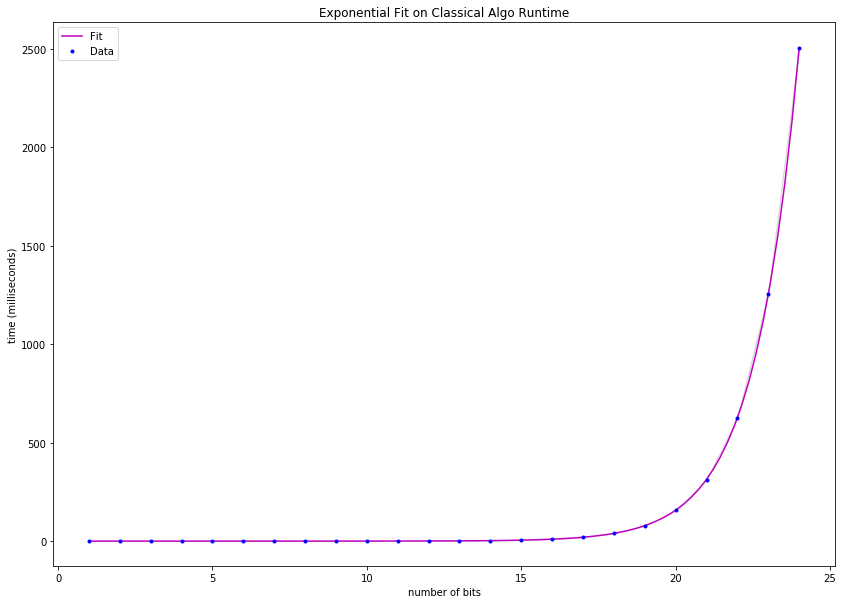

In [124]:
def exp(x, a, b, c):
    return a * 2**(b*(x-1)) + c

popt, pcov = curve_fit(exp, ns_con, const_time_means)

print("Fit parameters:", popt)
xs = np.linspace(ns_con[0], ns_con[-1], 100)
ys = exp(xs, *popt)

# Plot mean data points and fit
plt.figure(figsize=(14,10))
plt.plot(xs, ys * millisec, '-m')
plt.plot(ns_con, const_time_means * millisec, '.b')
plt.fill_between(ns_con, (const_time_means-const_time_stds) * millisec, 
                 (const_time_means+const_time_stds) * millisec, alpha=0.1, color='k')

plt.title('Exponential Fit on Classical Algo Runtime')
plt.xlabel('number of bits')
plt.ylabel('time (milliseconds)')
plt.legend(['Fit','Data'], loc='upper left')
# plt.savefig("Classical_constant_fitted")
plt.show()

The theory was spot on! $b = 0.9994 \approx 1$!!! This classical algorithm scales just like we expected. Doesn't it warm your heart when theory and experiment agree with each other? The classical results are all squared away. Next up is the quantum computer.

## Define Constant Circuits
The constnat circuits are just as simple as the classical constant functions. The two easiest constant functions are do nothing then the output is always 0, or have an $X$ gate and the output is always 1.

In [4]:
# Two possible constant U_f operations
def uf_const0(circuit, output_qubit):
    circuit.iden(output_qubit)

def uf_const1(circuit, output_qubit):
    circuit.x(output_qubit)

## Deterministic Quantum Algorithm: Deutsch-Jozsa
Below, I define the Deutsch-Jozsa algorithm in the function ```dj_algo_circuit``` and define a function to run and time it called ```quantum_algo```. Inside the ```dj_algo_circuit```, it's important to use the ```circuit.barrier()``` commands around the $U_f$. If we don't, the circuit will be optimized and the since our $U_f$ is so simple, the circuit will be very small. This is kind of cheating because, in theory, we want the algorithm to work for ANY $U_f$ not our cooked up very simple one which the optimizer will literally reduce down to just one or two gates. To tell qiskit to not optimize the whole circuit, we divide it up using the barrier commands. It will only optimize gates between barriers and between a barrier and a circuit boundary (i.e. the beginning or end of the circuit).

In [5]:
# uf is the U_f you wish to know whether it is balanced or constant and n is the number of INPUT (not total) qubits
def dj_algo_circuit(uf, n):
    circuit = QuantumCircuit(n+1, n)
    circuit.x(n)
    circuit.h(range(n+1))
    circuit.barrier()
    uf(circuit, n)
    circuit.barrier()
    circuit.h(range(n+1))
    circuit.measure(range(n), range(n))
    return circuit

def quantum_algo(uf, n, backend, shots):   
    circuit = dj_algo_circuit(uf, n)
    result = execute(circuit, backend, shots=shots).result()
    counts = result.get_counts(circuit)
    return counts, result.time_taken

## Timed Trial: Deutsch-Jozsa with a 5-Qubit Quantum Computer
Let's start with a small 5-qubit quantum computers. First, we'll find the least busy 5-qubit quantum computer. Then, we'll take the same approach as the classical algorithm's timed trial except the repetition number will be 10 instead of 100. Within each repetition, we need to decide how many shots the quantum computer should run. In an earlier version of this notebook, I did one shot per repetition, and the quantum computer classified $U_f$ as constant about 50% of the time—not very good (should be 100%). The more shots, the higher probability of getting the right answer, but also a longer data acquisition time.

In [21]:
IBMQ.load_account() # Load account from disk

/Users/Razander/anaconda3/lib/python3.6/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [22]:
# Filter backends to find the least busy 5 qubit quantum computer and check current "pending_jobs"
from qiskit.providers.ibmq import least_busy

provider = IBMQ.get_provider(hub='ibm-q')
smaller_qcs = provider.backends(filters=lambda x: x.configuration().n_qubits == 5 and not x.configuration().simulator)
backend_real = least_busy(smaller_qcs)

# Check status and "pending_jobs" to see how long it might take to run
backend_real.status()

BackendStatus(backend_name='ibmqx2', backend_version='2.0.5', operational=True, pending_jobs=1, status_msg='active')

In [37]:
reps = 10
qs_real_con = np.arange(1, 5)  # input qubits only goes up to 4 since last qubit on qc is needed as output qubit
shots_real = 10

# Initialize arrays that will store results
q_real_con_t = np.zeros(len(qs_real_con) * reps)
q_real_con_cs = {}

# Execute quantum circuit and view results
for j in range(reps):
    for i, n in enumerate(qs_real_con):
        index = i + j*len(qs_real_con)
        q_real_con_cs[index], q_real_con_t[index] = quantum_algo(uf_const0, int(n), backend_real, shots_real)


In [44]:
# Compute mean and standard deviation from runs
q_real_con_t = q_real_con_t.reshape(reps, len(qs_real_con))
q_real_con_t_means = np.mean(q_real_con_t, axis=0)
q_real_con_t_stds = np.std(q_real_con_t, axis=0)

# Add up number of 0 states from the repeated experiments
label_ave = 0
for rep, exp in q_real_con_cs.items():
    zero_state_counts = 0
    other_state_counts = 0
    for state, counts in exp.items():
        if 0==int(state):
            zero_state_counts += counts
        else:
            other_state_counts += counts
    if zero_state_counts > other_state_counts:
        label_ave += 0.0
    elif zero_state_counts == other_state_counts:
        label_ave += 0.5
    else:
        label_ave += 1.0
zero_state_ave = label_ave / len(q_real_con_cs)

Average label should be exactly 0: 0.1375


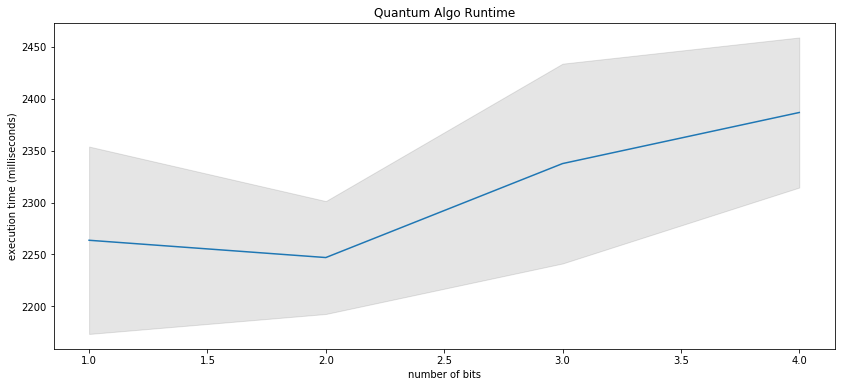

In [47]:
# Check it labeled the function correctly
print("Average label should be exactly 0:", zero_state_ave)

# Plot time it took to run algo
plt.figure(figsize=(14,6))
plt.plot(qs_real_con, q_real_con_t_means * millisec)
plt.fill_between(qs_real_con, (q_real_con_t_means-q_real_con_t_stds) * millisec, 
                 (q_real_con_t_means+q_real_con_t_stds) * millisec, alpha=0.1, color='k')

plt.title('Quantum Algo Runtime')
plt.xlabel('number of bits')
plt.ylabel('execution time (milliseconds)')
plt.show()

I might be getting ahead of myself but that looks linear! With so few data points it's really hard to be certain. Let's see what the fit parameters say. Notice the "Average label should be exactly 0:" value is 0.1375. That means the quantum computer miscategorized the function 13.75% of the time. I'd say that's pretty good, but still not great. Doing more shots would reduce this further.

Exponential fit parameters: [0.03436465 0.78291723 2.21614698]
Linear fit parameters: [0.04600616 2.19370074]


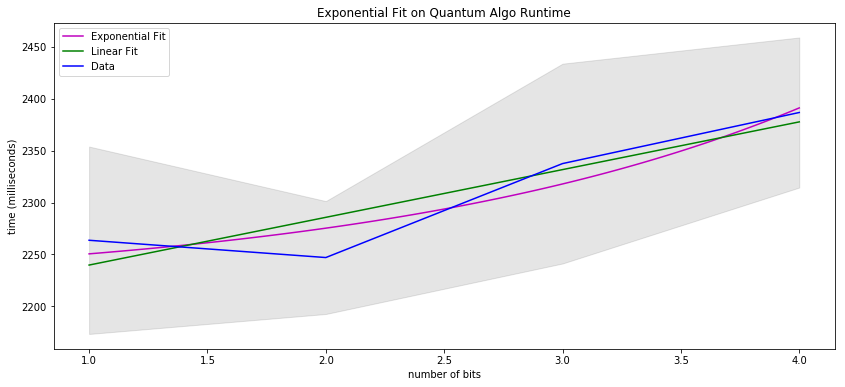

In [48]:
def exp(x, a, b, c):
    return a * 2**(b*(x-1)) + c

def linear(x, a, b):
    return a * x + b

popt_exp, pcov_exp = curve_fit(exp, qs_real_con, q_real_con_t_means)
popt_lin, pcov_lin = curve_fit(linear, qs_real_con, q_real_con_t_means)

print("Exponential fit parameters:", popt_exp)
print("Linear fit parameters:", popt_lin)
xs = np.linspace(1, 4, 100)
ys_exp = exp(xs, *popt_exp)
ys_lin = linear(xs, *popt_lin)

# Plot mean data points and fit
plt.figure(figsize=(14,6))
plt.plot(xs, ys_exp * millisec, '-m')
plt.plot(xs, ys_lin * millisec, '-g')
plt.plot(qs_real_con, q_real_con_t_means * millisec, '-b')
plt.fill_between(qs_real_con, (q_real_con_t_means-q_real_con_t_stds) * millisec, 
                 (q_real_con_t_means+q_real_con_t_stds) * millisec, alpha=0.1, color='k')

plt.title('Exponential Fit on Quantum Algo Runtime')
plt.xlabel('number of bits')
plt.ylabel('time (milliseconds)')
plt.legend(['Exponential Fit', 'Linear Fit', 'Data'], loc='upper left')
plt.savefig("Quantum_real_5qbuit_constant_fitted")
plt.show()

As I said, by eye, it really could be linear or exponential. The fit parameters don't help us much. If it is exponential, the important parameter $b$ is already less than 1, so that's improvement from the classical case, but it's definitely possibly exponential. There just aren't enough data points to distinguish between a linear and exponential trend. Luckily, IBM has a 15-qubit quantum computer available! :D Let's try that. For sake of time, I only ran 1 repetition, so I don't have any statistics on each data point.

## Timed Trial: Deutsch-Jozsa with a 15-Qubit Quantum Computer

In [246]:
backend_bigqc = provider.get_backend('ibmq_16_melbourne')
backend_bigqc.status()

BackendStatus(backend_name='ibmq_16_melbourne', backend_version='2.0.6', operational=True, pending_jobs=10, status_msg='active')

In [ ]:
reps = 1
qs_realbig_con = np.arange(1, 14)  # input qubits only goes up to 14 since last qubit on qc is needed as output qubit
shots_real = 1

# Initialize arrays that will store results
q_realbig_con_t = np.zeros(len(qs_realbig_con) * reps)
q_realbig_con_cs = {}

# Execute quantum circuit and view results
for j in range(reps):
    for i, n in enumerate(qs_realbig_con):
        index = i + j*len(qs_realbig_con)
        q_realbig_con_cs[index], q_realbig_con_t[index] = quantum_algo(uf_const0, int(n), backend_bigqc, shots_real)

In [272]:
# Compute mean and standard deviation from runs
q_realbig_con_t = q_realbig_con_t.reshape(reps, len(qs_realbig_con))
q_realbig_con_t_means = np.mean(q_realbig_con_t, axis=0)
q_realbig_con_t_stds = np.std(q_realbig_con_t, axis=0)

# Add up number of 0 states from the repeated experiments
label_ave = 0
for key1, val1 in q_realbig_con_cs.items():
    for key2, val2 in val1.items():
        if 0==int(key2):
            label_ave += 1
zero_state_ave = 1 - label_ave / len(q_realbig_con_cs)

Average label should be exactly 0: 0.7857142857142857


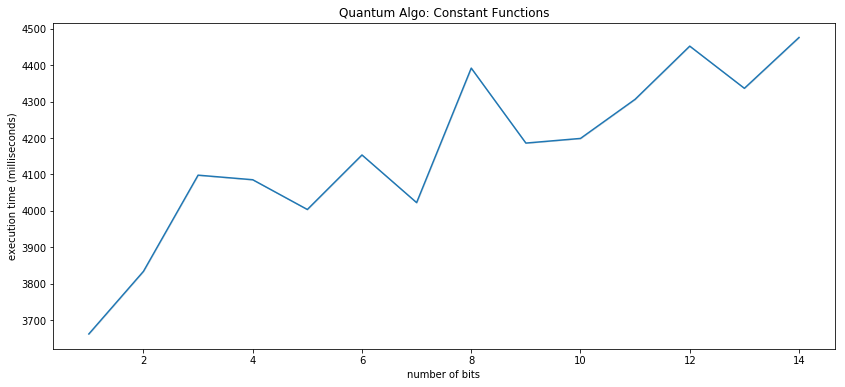

In [273]:
# Check it labeled the function correctly
print("Average label should be exactly 0:", zero_state_ave)

# Plot time it took to run algo
plt.figure(figsize=(14,6))
plt.plot(qs_realbig_con, q_realbig_con_t_means * millisec)
plt.fill_between(qs_realbig_con, (q_realbig_con_t_means-q_realbig_con_t_stds) * millisec, 
                 (q_realbig_con_t_means+q_realbig_con_t_stds) * millisec, alpha=0.1, color='k')

plt.title('Quantum Algo Runtime')
plt.xlabel('number of bits')
plt.ylabel('execution time (milliseconds)')
plt.show()

Now <strong>THAT</strong> looks linear! Beautiful!! The theory says it should be flat, but some slope is not a problem. It can easily be swept under the rug as overhead in using more gates and measurements for higher qubit numbers or something like that. The important point is that IT'S NOT EXPONENTIAL! Sure enough, if you look at the fit parameter on the exponent (not plotted, but still computed below), it's very small $b=0.0000340$ implying a linear fit is the right one to use.

Exponential fit parameters: [ 2.07463601e+03  3.40429123e-05 -2.07079676e+03]
Linear fit parameters: [0.04896331 3.79026877]


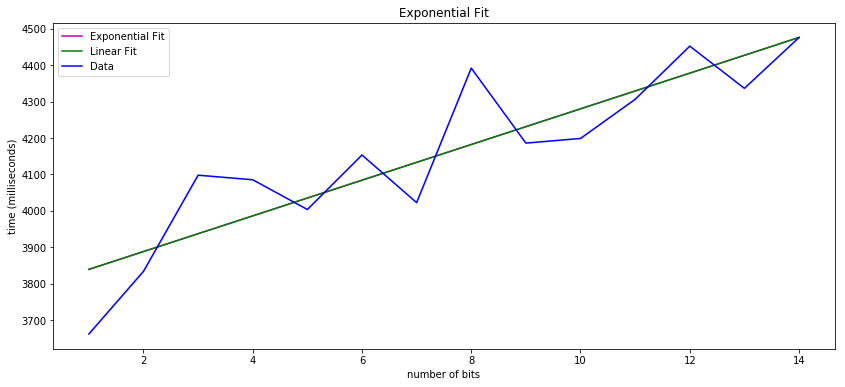

In [297]:
def exp(x, a, b, c):
    return a * 2**(b*(x-1)) + c

def linear(x, a, b):
    return a * x + b

popt_exp, pcov_exp = curve_fit(exp, qs_realbig_con, q_realbig_con_t_means, maxfev=5000)
popt_lin, pcov_lin = curve_fit(linear, qs_realbig_con, q_realbig_con_t_means)

print("Exponential fit parameters:", popt_exp)
print("Linear fit parameters:", popt_lin)

xs = np.linspace(qs_realbig_con[0], qs_realbig_con[-1], 100)
ys_exp = exp(xs, *popt_exp)
ys_lin = linear(xs, *popt_lin)

# Plot mean data points and fit
plt.figure(figsize=(14,6))
plt.plot(xs, ys_lin * millisec, '-g')
plt.plot(qs_realbig_con, q_realbig_con_t_means * millisec, '-b')
plt.fill_between(qs_realbig_con, (q_realbig_con_t_means-q_realbig_con_t_stds) * millisec, 
                 (q_realbig_con_t_means+q_realbig_con_t_stds) * millisec, alpha=0.1, color='k')

plt.title('Linear Fit on Quantum Algo Runtime')
plt.xlabel('number of bits')
plt.ylabel('time (milliseconds)')
plt.legend(['Linear Fit','Data'], loc='upper left')
plt.savefig("Quantum_real_15qbuit_constant_fitted")
plt.show()

Now, when does quantum win in this battle of fastest algorithm?

# When does QC Beat C?

With the fits from the classical and quantum runs, we can answer actually answer some real life questions like: how many inputs bits/qubits does a 2020 quantum computer need to beat a 2020 classical computer laptop?

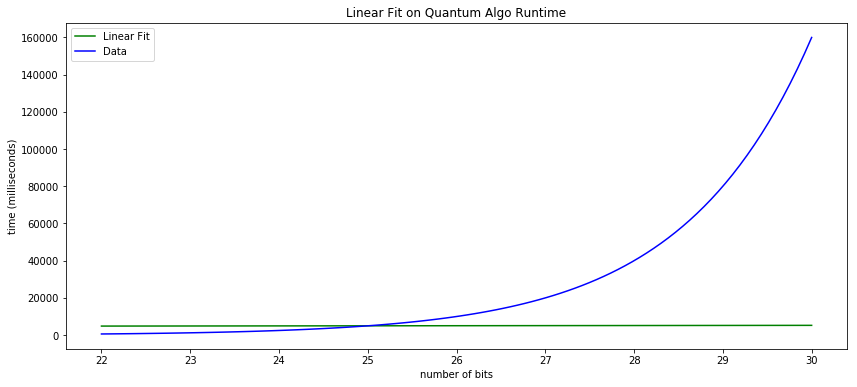

In [153]:
quan_popt = [0.04896331, 3.79026877]
clas_popt = [3.01288381e-07,  9.99435938e-01, -1.31329863e-04]

xs = np.linspace(22, 30, 100)
ys_q_lin = linear(xs, *quan_popt)
ys_c_exp = exp(xs, *clas_popt)

# Plot mean data points and fit
plt.figure(figsize=(14,6))
plt.plot(xs, ys_q_lin * millisec, '-g')
plt.plot(xs, ys_c_exp * millisec, '-b')

plt.title('Linear Fit on Quantum Algo Runtime')
plt.xlabel('number of bits')
plt.ylabel('time (milliseconds)')
plt.legend(['Linear Fit','Data'], loc='upper left')
plt.savefig("Quantum_real_15qbuit_constant_fitted")
plt.show()

Answer: $\gt25$! Looks like at 25 input bits/qubits is where the two are evenly matched, but after that the quantum computer would be WAY (exponentially in fact) faster!

## Age of the Universe Calculation
At what point will the classical computer take the age of the universe just to discover our chosen $f(x)$ is constant? Let's assume the age of the universe is ~$14$ billion years—about $4.418 \cdot 10^{17}$ seconds—and solving the exponential fit equation for $n$ gives $n = \frac{\ln{\left(\frac{f(x) - c}{a}\right)}}{b\ln(2)} + 1$.

In [154]:
age_of_uni_y = 14e9  # age of the universe in years
age_of_uni_s= age_of_uni_y * 365.25 * 24 * 3600  # age of the universe in seconds

n = np.log((age_of_uni_s - clas_popt[2]) / clas_popt[0]) / (clas_popt[1] * np.log(2)) + 1
print('Number of input bits:', int(n))

Number of input bits: 81


81! Hahaha that's still double digits! That's NOTHING! The best part about this is we're almost there! Google, IBM, and IonQ are already have quantum computers in the 30s - 50s of qubits!